In [35]:
!pip install opencv-python-headless numpy click

In [36]:
import cv2
import numpy as np
import click

CONTEXT_SETTINGS = dict(help_option_names=["-h", "--help"])


def convolution(img, kernel):
    """ This function executes the convolution between `img` and `kernel`.
    """
    print("[{}]\tRunning convolution...\n".format(img))
    # Load the image.
    image = cv2.imread(img)
    # Flip template before convolution.
    kernel = cv2.flip(kernel, -1)
    # Get size of image and kernel. 3rd value of shape is colour channel.
    (image_h, image_w) = image.shape[:2]
    (kernel_h, kernel_w) = kernel.shape[:2]
    (pad_h, pad_w) = (kernel_h // 2, kernel_w // 2)
    # Create image to write to.
    output = np.zeros(image.shape)
    # Slide kernel across every pixel.
    for y in range(pad_h, image_h - pad_h):
        for x in range(pad_w, image_w - pad_w):
            # If coloured, loop for colours.
            for colour in range(image.shape[2]):
                # Get center pixel.
                center = image[
                    y - pad_h : y + pad_h + 1, x - pad_w : x + pad_w + 1, colour
                ]
                # Perform convolution and map value to [0, 255].
                # Write back value to output image.
                output[y, x, colour] = (center * kernel).sum() / 255

    # Return the result of the convolution.
    return output


def fourierM(img, kernel):
    """ Compute convolution between `img` and `kernel` using numpy's FFT.
    """
    # Load the image.
    image = cv2.imread(img)
    # Get size of image and kernel.
    (image_h, image_w) = image.shape[:2]
    (kernel_h, kernel_w) = kernel.shape[:2]
    # Apply padding to the kernel.
    padded_kernel = np.zeros(image.shape[:2])
    start_h = (image_h - kernel_h) // 2
    start_w = (image_w - kernel_w) // 2
    padded_kernel[start_h : start_h + kernel_h, start_w : start_w + kernel_w] = kernel
    # Create image to write to.
    output = np.zeros(image.shape)
    # Run FFT on all 3 channels.
    for colour in range(3):
        Fi = np.fft.fft2(image[:, :, colour])
        Fk = np.fft.fft2(padded_kernel)
        # Inverse fourier.
        output[:, :, colour] = np.fft.fftshift(np.fft.ifft2(Fi * Fk)) / 255

    # Return the result of convolution.
    return output


def gaussian_blur(image, sigma, fourier):
    """ Builds a Gaussian kernel used to perform the LPF on an image.
    """
    print("[{}]\tCalculating Gaussian kernel...".format(image))

    # Calculate size of filter.
    size = 8 * sigma + 1
    if not size % 2:
        size = size + 1

    center = size // 2
    kernel = np.zeros((size, size))

    # Generate Gaussian blur.
    for y in range(size):
        for x in range(size):
            diff = (y - center) ** 2 + (x - center) ** 2
            kernel[y, x] = np.exp(-diff / (2 * sigma ** 2))

    kernel = kernel / np.sum(kernel)

    if fourier:
        return fourierM(image, kernel)
    else:
        return convolution(image, kernel)


def low_pass(image, cutoff, fourier):
    """ Generate low pass filter of image.
    """
    print("[{}]\tGenerating low pass image...".format(image))
    return gaussian_blur(image, cutoff, fourier)


def high_pass(image, cutoff, fourier):
    """ Generate high pass filter of image. This is simply the image minus its
    low passed result.
    """
    print("[{}]\tGenerating high pass image...".format(image))
    return (cv2.imread(image) / 255) - low_pass(image, cutoff, fourier)


def hybrid_image(image, cutoff, fourier):
    """ Create a hybrid image by summing together the low and high frequency
    images.
    """
    # Perform low pass filter and export.
    low = low_pass(image[0], cutoff[0], fourier)
    cv2.imwrite("low.jpg", low * 255)
    # Perform high pass filter and export.
    high = high_pass(image[1], cutoff[1], fourier)
    cv2.imwrite("high.jpg", (high + 0.5) * 255)

    print("Creating hybrid image...")
    # Resize the smaller image to match the dimensions of the larger image
    if low.shape != high.shape:
        if low.shape[0] > high.shape[0] and low.shape[1] > high.shape[1]:
            high = cv2.resize(high, (low.shape[1], low.shape[0]))
        else:
            low = cv2.resize(low, (high.shape[1], high.shape[0]))

    return low + high


def output_vis(image):
    """ Display hybrid image comparison for report. Visualisation shows 5 images
    reducing in size to simulate viewing the image from a distance.
    """
    print("Creating visualisation...")

    num = 5  # Number of images to display.
    gap = 2  # Gap between images (px).

    # Create list of images.
    image_list = [image]
    max_height = image.shape[0]
    max_width = image.shape[1]

    # Add images to list and increase max width.
    for i in range(1, num):
        tmp = cv2.resize(image, (0, 0), fx=0.5 ** i, fy=0.5 ** i)
        max_width += tmp.shape[1] + gap
        image_list.append(tmp)

    # Create space for image stack.
    stack = np.ones((max_height, max_width, 3)) * 255

    # Add images to stack.
    current_x = 0
    for img in image_list:
        stack[
            max_height - img.shape[0] :, current_x : img.shape[1] + current_x, :
        ] = img
        current_x += img.shape[1] + gap

    return stack





In [46]:

@click.group(context_settings=CONTEXT_SETTINGS)
def main():
    """ Hybrid image demonstration program.
    """
    pass


@main.command()
@click.argument("image", type=str, nargs=1)
@click.option("-o", "--output", default="output.jpg", help="Output file.")
@click.option("-s", "--size", nargs=2, type=int, help="Kernel dimensions.")
def kernel(**kwargs):
    """ Demonstrate the effect of kernel size.
    """
    if any(s % 2 == 0 for s in kwargs["size"]):
        print("Kernel dimensions must be odd!")
        exit()

    kernel = np.ones(kwargs["size"], dtype="float") * (
        255.0 / (kwargs["size"][0] * kwargs["size"][1])
    )
    result = convolution(kwargs["image"], kernel)
    cv2.imwrite(kwargs["output"], result)


@main.command()
@click.argument("images", type=str, nargs=2)
@click.option("-o", "--output", default="output.jpg", help="Output file.")
@click.option(
    "-c",
    "--cutoff",
    default=[4, 4],
    type=int,
    nargs=2,
    help="High/low cutoff frequencies.",
)
@click.option(
    "-v", "--visual", is_flag=True, default=False, help="Generate visualisation."
)
@click.option(
    "-f", "--fourier", is_flag=True, default=False, help="Use fourier convolution."
)
def hybrid(**kwargs):
    """ Create hybrid image from two source images.
    """
    hybrid = hybrid_image(kwargs["images"], kwargs["cutoff"], kwargs["fourier"])

    if kwargs["visual"]:
        cv2.imwrite(kwargs["output"], output_vis(hybrid) * 255)
    else:
        cv2.imwrite(kwargs["output"], hybrid * 255)



@main.command()
@click.argument("image", type=str, nargs=1)
@click.option("-o", "--output", default="output.jpg", help="Output file.")
def sobel(**kwargs):
    """ Perform sobel edge detection.
    """
    sobel_x = fourierM(
        kwargs["image"], 255 * np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    )
    sobel_y = fourierM(
        kwargs["image"], 255 * np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    )

    cv2.imwrite(kwargs["output"].split(".")[0] + "_x.jpg", sobel_x)
    cv2.imwrite(kwargs["output"].split(".")[0] + "_y.jpg", sobel_y)
    cv2.imwrite(kwargs["output"].split(".")[0] + "_xy.jpg", sobel_x + sobel_y)


#Upload 2 images

In [52]:
import sys
import os
from google.colab import files
import matplotlib.pyplot as plt

# Upload images
uploaded = files.upload()
# Rename the uploaded files
new_names = ["image1.jpg", "image2.jpg"]  # Desired names for the first two files
count = 0
for filename in list(uploaded.keys()):
    if count < len(new_names):
        new_filename = new_names[count]
        os.rename(filename, new_filename)  # Rename the file
        print(f"Renamed '{filename}' to '{new_filename}'")
        count += 1



Saving cat.jpg to cat.jpg
Saving dog.jpg to dog.jpg
Renamed 'cat.jpg' to 'image1.jpg'
Renamed 'dog.jpg' to 'image2.jpg'


[image2.jpg]	Generating low pass image...
[image2.jpg]	Calculating Gaussian kernel...


<ipython-input-36-7bf38daf7735>:59: ComplexWarning: Casting complex values to real discards the imaginary part
  output[:, :, colour] = np.fft.fftshift(np.fft.ifft2(Fi * Fk)) / 255


[image1.jpg]	Generating high pass image...
[image1.jpg]	Generating low pass image...
[image1.jpg]	Calculating Gaussian kernel...
Creating hybrid image...
Creating visualisation...
Command executed successfully.


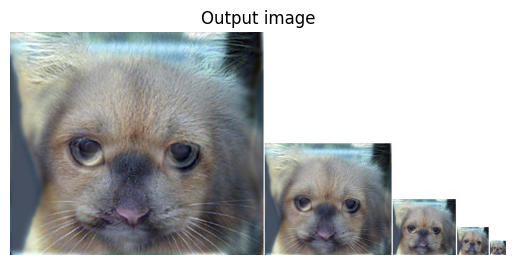

In [54]:
# Set command-line arguments
sys.argv = ['script_name', 'hybrid', '-f','-v', 'image2.jpg', 'image1.jpg', '-o', 'output.jpg']

# Run the main function
try:
    main()
except SystemExit as e:
    # Handle the SystemExit exception raised by click
    if e.code == 0:
        print("Command executed successfully.")
    else:
        print("Command failed with exit code:", e.code)

        # Display the output image
plt.figure()
plt.title('Output image')
output_img = cv2.cvtColor(cv2.imread('/content/output.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(output_img)
plt.axis('off')
plt.show()